In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

In [2]:
from pydantic import BaseModel
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from autoamp.finetune import Sequence
from autoamp.finetune import read_fasta
from autoamp.finetune import write_fasta
from autoamp.mmseqs import mmseqs2_cluster
from autoamp.evolve import mutate_sequence
from autoamp.evolve import MutatedSequence
from autoamp.evolve import Esm2ProteinLangaugeModel
from autoamp.evolve import EnsemblePLM
from autoamp.filters import LengthFilter
from autoamp.filters import  DAminoAcidsFilter
from autoamp.filters import UnknownAminoAcidsFilter
from autoamp.filters import ChargeFilter
from autoamp.filters import HydrophobicFilter
from autoamp.filters import PHAdjustmentFilter
from autoamp.filters import NTerminalFilter
from autoamp.filters import DisallowedPairsFilter
from autoamp.filters import BetaSheetFilter
from autoamp.filters import DuplicateFilter
from autoamp.filters import FilterChain

2025-01-18 21:37:24.682156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 21:37:24.707191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 21:37:24.707222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 21:37:24.720569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-18 21:37:34.694528: W tensorflow/compiler/tf

In [3]:
class AMPSequence(BaseModel):
    # These two properties are necessary for duck typing the autoamp.finetune.Sequence API
    sequence: str
    tag: str

    # These are extra parameters specific to the AMPSphere dataset
    accession: str
    family: str
    length: int
    molecular_weight: float
    isoelectric_point: float
    charge: float
    aromaticity: float
    instability_index: float
    gravy: float
    Antifam: str
    RNAcode: str
    metaproteomes: str
    metatranscriptomes: str
    Coordinates: str

    def __hash__(self) -> int:
        """Hash the sequence to use it as a key in a dictionary."""
        return hash((self.sequence, self.tag))

def load_amp_sequences(path: str) -> list[AMPSequence]:
    data = Path(path).read_text().splitlines()
    header = data[0].split("\t")
    lines = data[1:]
    sequences = []
    for line in lines:
        entry = dict(zip(header, line.split("\t")))
        # Manually add the tag to duck type against Sequence API
        entry["tag"] = entry["accession"]
        sequences.append(AMPSequence(**entry))
    return sequences

In [44]:
#data_path = "/nfs/lambda_stor_01/homes/abrace/projects/sdl-amp/data/AMP.tsv"

#sequences = load_amp_sequences(data_path)

sequences = [Sequence('QSALTQPASVSGSPGQSITISCTGTSNDVGSYTLVSWYQQYPGKAPKLLIFEGTKRSSGISNRFSGSKSGNTASLTISGLQGEDEADYYCCSYAGASTFVFGGGTKLTVL', 'test1')]

#sequences = [Sequence('EVQLVESGGGLVQPGGSLRLSCAASGFSVSTKYMTWVRQAPGKGLEWVSVLYSGGSDYYADSVKGRFTISRDNSKNALYLQMNSLRVEDTGVYYCARDSSEVRDHPGHPGRSVGAFDIWGQGTMVTVSS','test1')] 

In [45]:
# Setup the filters to clean the data
filters = [
        LengthFilter(threshold=30),
        DAminoAcidsFilter(),
        UnknownAminoAcidsFilter(),
        ChargeFilter(threshold=0.25),
        HydrophobicFilter(threshold=0.5),
        PHAdjustmentFilter(threshold=0.75),
        NTerminalFilter(),
        DisallowedPairsFilter(),
        BetaSheetFilter(),
        DuplicateFilter(),
    ]

# Chain the filters
chain = FilterChain(filters=filters, verbose=True)

# Filter the sequences
#sequences = chain.apply(sequences)

In [46]:
# Setup the mutation models
esm2_8m_base_model = Esm2ProteinLangaugeModel(
    pretrained_model_name_or_path='facebook/esm2_t6_8M_UR50D',
    batch_size=32,
)

esm2_35m_base_model = Esm2ProteinLangaugeModel(
    pretrained_model_name_or_path='facebook/esm2_t12_35M_UR50D',
    batch_size=16,
)

esm2_150m_base_model = Esm2ProteinLangaugeModel(
    pretrained_model_name_or_path='facebook/esm2_t30_150M_UR50D',
    batch_size=4,
)

esm2_650m_base_model = Esm2ProteinLangaugeModel(
    pretrained_model_name_or_path='facebook/esm2_t33_650M_UR50D',
    batch_size=4,
)

# Create the ensemble of protein language models
ensemble = EnsemblePLM(
    models=[
        esm2_8m_base_model,
        esm2_35m_base_model,
        esm2_150m_base_model,
        esm2_650m_base_model,
    ],
    # All the models must agree on the proposed mutation
    consensus_threshold=2,
)

In [47]:
# Run the model on the sequences to suggest plausible mutations
mutants = ensemble.infer(sequences)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.29it/s]


In [48]:
print("Predicted mutants:", len(mutants))

Predicted mutants: 0


In [30]:
for i in range(len(mutants)):
    print(mutants[i].mutation)

Mutation(position=31, wildtype='K', mutant='Y')
Mutation(position=34, wildtype='T', mutant='H')
Mutation(position=90, wildtype='G', mutant='A')


In [18]:
#from pprint import pprint
#pprint(mutants)


In [9]:
# Reapply the filters on the mutant sequences
mutants_filtered = set(chain.apply([x.mutated_sequence for x in mutants]))

# Reindex the mutants to exclude the filtered ones
mutants = [x for x in mutants if x.mutated_sequence in mutants_filtered]

print("Filtered mutants:", len(mutants))

Initial number of sequences: 1291
LengthFilter filtered 0
DAminoAcidsFilter filtered 0
UnknownAminoAcidsFilter filtered 0
ChargeFilter filtered 14
HydrophobicFilter filtered 12
PHAdjustmentFilter filtered 4
NTerminalFilter filtered 0
DisallowedPairsFilter filtered 0
BetaSheetFilter filtered 1
DuplicateFilter filtered 9
Total filtered: 40 or 96.90%
Final number of sequences: 1251
Filtered mutants: 1251


# Plot pLM embeddings using sequence propertes

In [10]:
def plot_tsne(
    X_tsne: np.ndarray,
    y: np.ndarray,
    color_label: str,
    selected_indices: np.ndarray | None = None,
    title: str = '',
) -> None:
    # Create a DataFrame for the t-SNE results
    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['label'] = y
    
    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        x=df_tsne['Component 1'], y=df_tsne['Component 2'], 
        c=df_tsne['label'], cmap='viridis', alpha=0.7
    )

    # Plot stars at the selected indices
    if selected_indices is not None:
        plt.scatter(
            x=df_tsne.loc[selected_indices, 'Component 1'],
            y=df_tsne.loc[selected_indices, 'Component 2'],
            color='red',
            marker='*',
            s=100,
            label='Selected Points'
        )
    
    # Enhance plot aesthetics
    plt.colorbar(scatter, label=color_label)
    plt.title(title)
    plt.xlabel(r'$z_1$')
    plt.ylabel(r'$z_2$')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
# Extract sequence embeddings from the best model
embeddings = np.array([x.plm_outputs["facebook/esm2_t33_650M_UR50D"].sequence_embeddings for x in mutants])

print("Embeddings:", embeddings.shape)

# Create a t-SNE model and fit it to the data
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(embeddings)

Embeddings: (1251, 1280)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


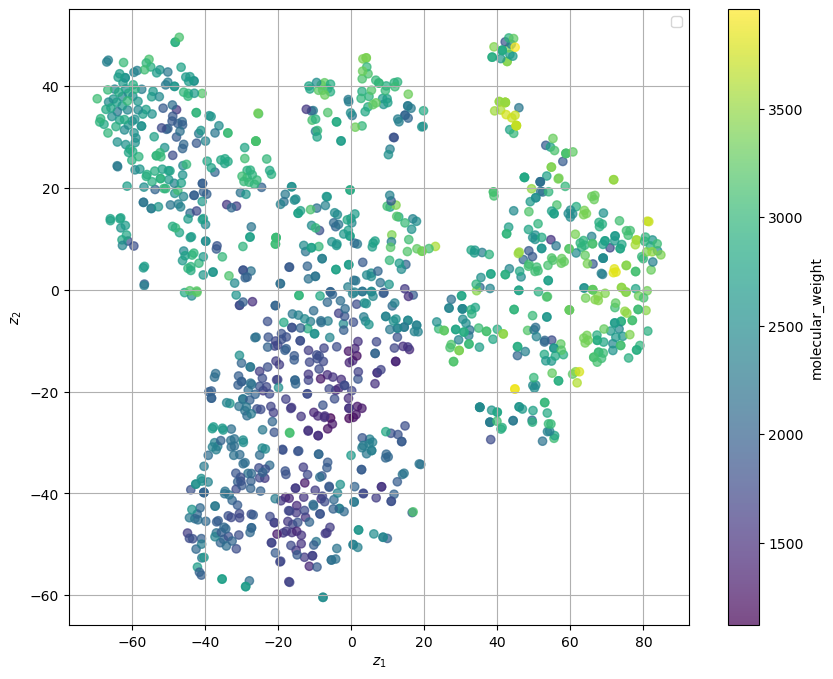

In [12]:
color = [x.sequence.molecular_weight for x in mutants]
plot_tsne(X_tsne, color, color_label="molecular_weight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


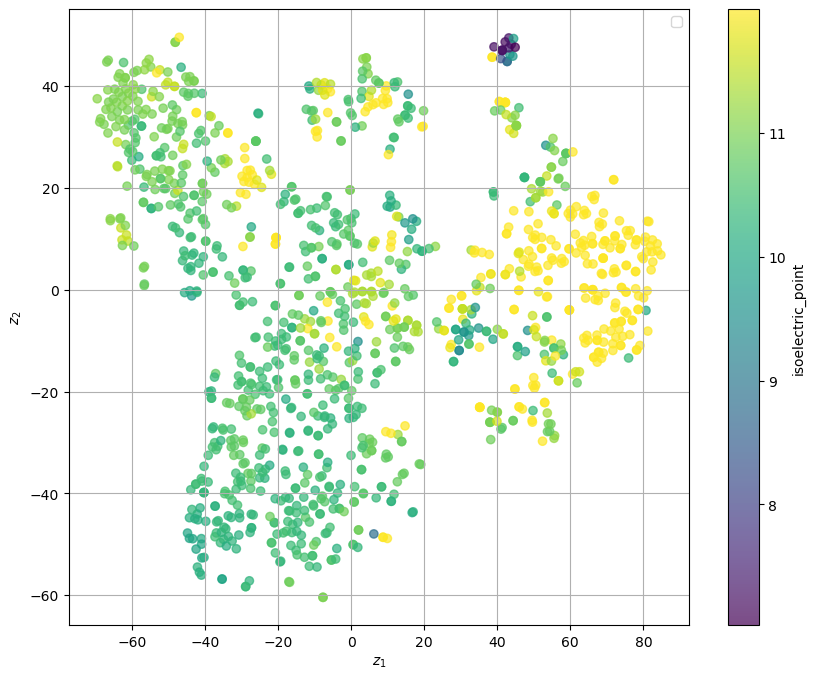

In [13]:
color = [x.sequence.isoelectric_point for x in mutants]
plot_tsne(X_tsne, color, color_label="isoelectric_point")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


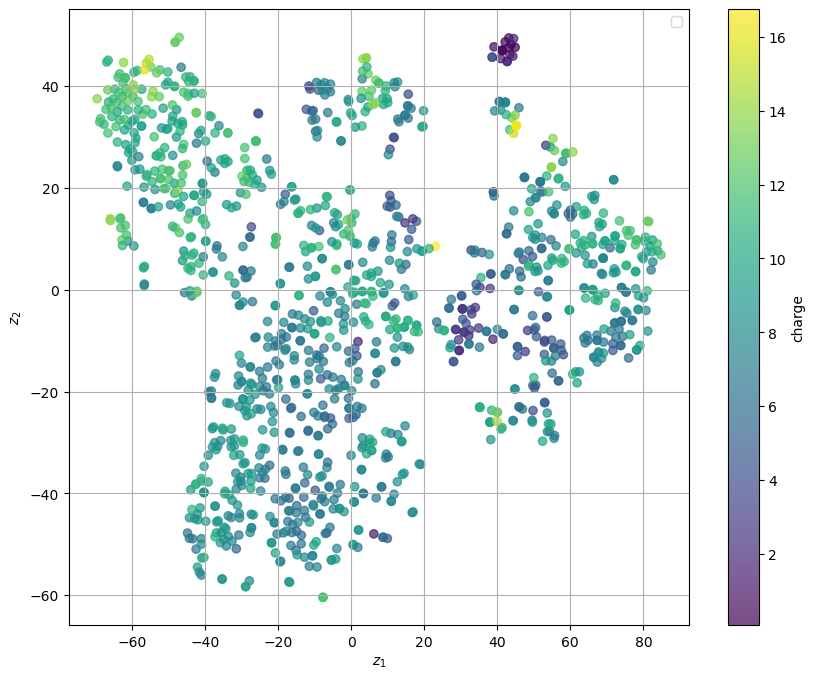

In [14]:
color = [x.sequence.charge for x in mutants]
plot_tsne(X_tsne, color, color_label="charge")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


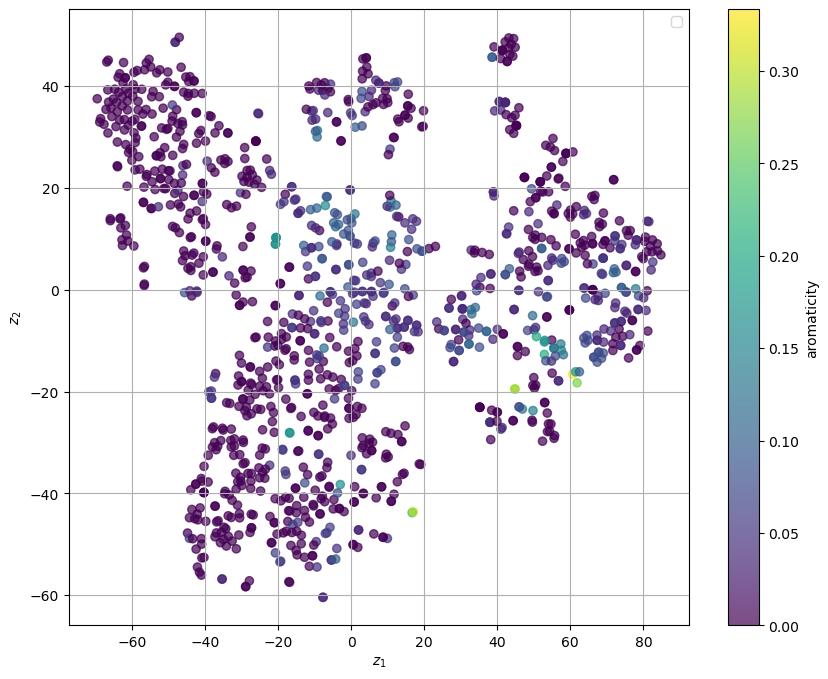

In [15]:
color = [x.sequence.aromaticity for x in mutants]
plot_tsne(X_tsne, color, color_label="aromaticity")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


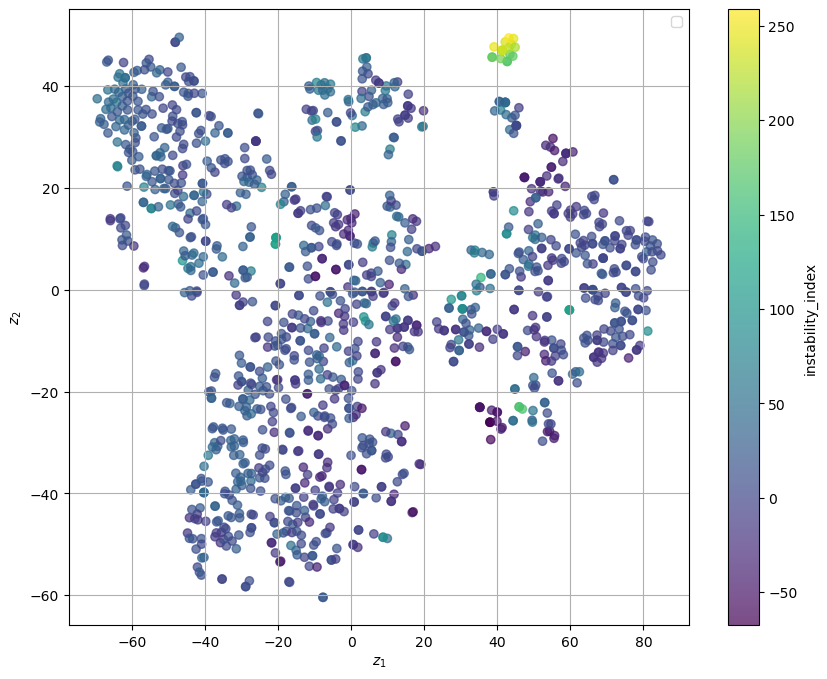

In [16]:
color = [x.sequence.instability_index for x in mutants]
plot_tsne(X_tsne, color, color_label="instability_index")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


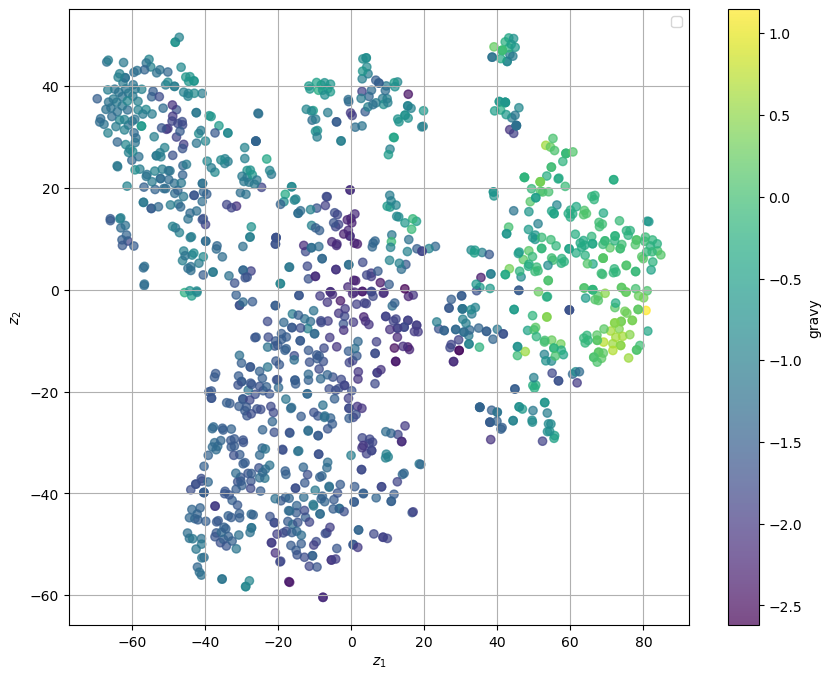

In [17]:
color = [x.sequence.gravy for x in mutants]
plot_tsne(X_tsne, color, color_label="gravy")

# Select a subset for experiment

In [19]:
# Total sequence budget
num_sequences = 350
# Number of sequence candidates (including mutants) from DBAASP
dbaasp_size = 58
# Number of control sequences
control_size = 8
# Number of wildtypes to select
ampsphere_size = (num_sequences - dbaasp_size) // 2
ampsphere_size -= control_size

print("Number of AMPSphere sequences to select", ampsphere_size)

Number of AMPSphere sequences to select 138


In [20]:
# We will use mmseqs to check how diverse the candidate selection policies are

def check_mmseqs_diversity(
    mutants: list[MutatedSequence],
    select_indices: np.ndarray,
    expected_number: int,
    min_seq_id: float = 0.5,
    cluster_coverage: float = 0.8,
    cov_mode: int = 1
) -> None:
    """Run mmseqs2 to check how diverse the selection was (we want maximal diversity)."""

    # Get the wildtype sequences
    wildtype_sequences = [mutant.sequence for mutant in mutants]
    # Get the subset of wildtypes selected by the policy
    wildtype_sequences = [wildtype_sequences[i] for i in select_indices]
    # Run mmseqs2 to see if the mmseqs clusters is close to the ampsphere_size
    cluster_groups = mmseqs2_cluster(wildtype_sequences, min_seq_id=min_seq_id, cluster_coverage=cluster_coverage, cov_mode=cov_mode)
    print("Expected number of clusers:", expected_number)
    print("Actual number of mmseqs2 clusters:", len(cluster_groups))

## Try selecting candidates at random

In [21]:
np.random.seed(42)
random_indices = np.random.choice(len(embeddings), ampsphere_size, replace=False)

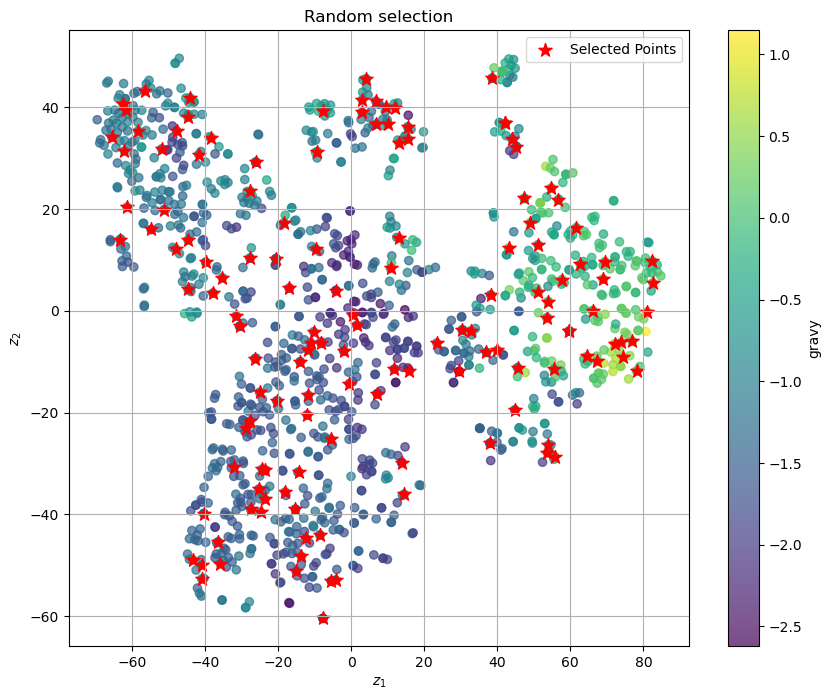

In [22]:
color = [x.sequence.gravy for x in mutants]
plot_tsne(X_tsne, color, color_label="gravy", title="Random selection", selected_indices=random_indices)

In [23]:
# Run mmseqs2 to check how diverse the selection was (we want maximal diversity)
check_mmseqs_diversity(mutants, random_indices, expected_number=ampsphere_size)

Expected number of clusers: 138
Actual number of mmseqs2 clusters: 108


## Try selecting candidates by first running a K-means clustering and then selecting 1 point per cluster at random

In [24]:
def select_random_subset_with_clustering(embeddings, subset_size, n_clusters):
    # Set random seed
    np.random.seed(42)
    
    # Step 1: Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    # Initialize selected indices
    selected_indices = []
    
    # Step 2: Randomly select points from each cluster
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        
        if len(cluster_indices) > 0:
            # Randomly sample points from the cluster
            n_samples = min(len(cluster_indices), subset_size // n_clusters)
            random_sampled_indices = np.random.choice(cluster_indices, n_samples, replace=False)
            selected_indices.extend(random_sampled_indices)
    
    # If we need more points to reach the desired subset_size, fill the remaining spots randomly
    if len(selected_indices) < subset_size:
        print("Filling subset", subset_size - len(selected_indices))
        remaining_indices = list(set(range(len(embeddings))) - set(selected_indices))
        additional_samples = np.random.choice(remaining_indices, subset_size - len(selected_indices), replace=False)
        selected_indices.extend(additional_samples)
    
    return selected_indices

In [25]:
cluster_random_inds = select_random_subset_with_clustering(embeddings, subset_size=ampsphere_size, n_clusters=ampsphere_size)

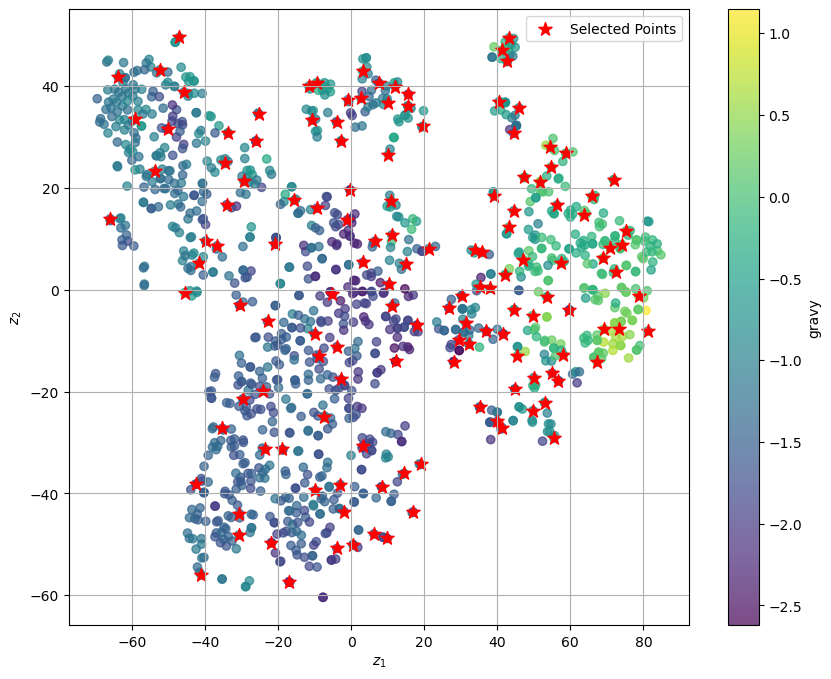

In [26]:
color = [x.sequence.gravy for x in mutants]
plot_tsne(X_tsne, color, color_label="gravy", selected_indices=cluster_random_inds)

In [27]:
# Run mmseqs2 to check how diverse the selection was (we want maximal diversity)
check_mmseqs_diversity(mutants, cluster_random_inds, expected_number=ampsphere_size)

Expected number of clusers: 138
Actual number of mmseqs2 clusters: 131


## Try selecting points by first running K-means and then selecting the point closest to each centroid

In [28]:
def select_closest_to_centroid_subset_with_clustering(embeddings, subset_size, n_clusters):
    # Step 1: Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    centroids = kmeans.cluster_centers_
    
    # Initialize selected indices
    selected_indices = []
    
    # Step 2: Select the point closest to the centroid from each cluster
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        
        if len(cluster_indices) > 0:
            # Calculate distances from the centroid
            distances = cdist(embeddings[cluster_indices], [centroids[cluster]], 'euclidean')
            closest_index = cluster_indices[np.argmin(distances)]
            selected_indices.append(closest_index)
    
    # If we need more points to reach the desired subset_size, fill the remaining spots randomly
    if len(selected_indices) < subset_size:
        print("Filling subset", subset_size - len(selected_indices))
        remaining_indices = list(set(range(len(embeddings))) - set(selected_indices))
        additional_samples = np.random.choice(remaining_indices, subset_size - len(selected_indices), replace=False)
        selected_indices.extend(additional_samples)
    
    return selected_indices

In [29]:
cluster_centroid_inds = select_closest_to_centroid_subset_with_clustering(embeddings, subset_size=ampsphere_size, n_clusters=ampsphere_size)

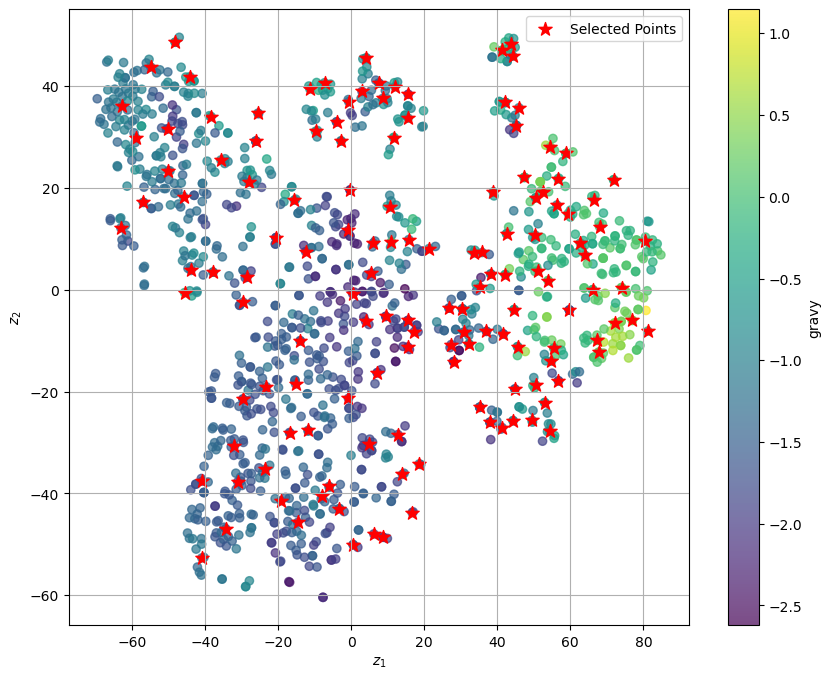

In [30]:
color = [x.sequence.gravy for x in mutants]
plot_tsne(X_tsne, color, color_label="gravy", selected_indices=cluster_centroid_inds)

In [31]:
# Run mmseqs2 to check how diverse the selection was (we want maximal diversity)
check_mmseqs_diversity(mutants, cluster_centroid_inds, expected_number=ampsphere_size)

Expected number of clusers: 138
Actual number of mmseqs2 clusters: 120


In [32]:
# Manually select the best selection policy
cluster_inds = cluster_random_inds

In [33]:
# Collect the candidate sequences
candidate_sequences = []

# Get the mutant subset from the selection policy
mutants_subset = [mutants[i] for i in cluster_inds]

for mutant in mutants_subset:
    wildtype_seq = Sequence(sequence=mutant.sequence.sequence, tag=f"wildtype [{mutant.sequence.tag}]")
    mutation_tag = f"p.{mutant.mutation.wildtype}{mutant.mutation.position}{mutant.mutation.mutant}"
    mutant_seq = Sequence(sequence=mutant.mutated_sequence.sequence, tag=f"mutant [{mutant.sequence.tag}] [{mutation_tag}]")
    candidate_sequences.append(wildtype_seq)
    candidate_sequences.append(mutant_seq)

# Write a fasta file with the experiment candidates
print(f"Writing {len(candidate_sequences)} sequences")
write_fasta(candidate_sequences, f"ampsphere_esm2_predicted_candidates_{ampsphere_size}mutants.fasta")

Writing 276 sequences


In [34]:
# Print the sequences to the notebook
for seq in candidate_sequences:
    print(f">{seq.tag}\n{seq.sequence}")

>wildtype [AMP10.194_657]
GLRSGGKAIKKSMGKALRGGGKVMR
>mutant [AMP10.194_657] [p.M12G]
GLRSGGKAIKKSGGKALRGGGKVMR
>wildtype [AMP10.440_996]
AAKAKAKPSKGKAKPMPKGKGKKGC
>mutant [AMP10.440_996] [p.C24K]
AAKAKAKPSKGKAKPMPKGKGKKGK
>wildtype [AMP10.051_032]
VRVRVKVRVRVRFSVRVRLS
>mutant [AMP10.051_032] [p.K5R]
VRVRVRVRVRVRFSVRVRLS
>wildtype [AMP10.189_244]
AMKKGKGGKGGGGKKC
>mutant [AMP10.189_244] [p.M1G]
AGKKGKGGKGGGGKKC
>wildtype [AMP10.268_455]
PKGIGYGKKNMKGRKGKGRKGK
>mutant [AMP10.268_455] [p.Y5K]
PKGIGKGKKNMKGRKGKGRKGK
>wildtype [AMP10.122_423]
RRGGREPGGRPGGGAGMGGWGGKRGEGRS
>mutant [AMP10.122_423] [p.K22G]
RRGGREPGGRPGGGAGMGGWGGGRGEGRS
>wildtype [AMP10.440_947]
AAAKKAAAKKPEAKKAAKKAAPKKK
>mutant [AMP10.440_947] [p.E11A]
AAAKKAAAKKPAAKKAAKKAAPKKK
>wildtype [AMP10.264_173]
GERVGVRVRVRVMVRMSA
>mutant [AMP10.264_173] [p.M12R]
GERVGVRVRVRVRVRMSA
>wildtype [AMP10.472_886]
KMTKMMNMMKIMRTHSMKMMRTHFMKPS
>mutant [AMP10.472_886] [p.F23S]
KMTKMMNMMKIMRTHSMKMMRTHSMKPS
>wildtype [AMP10.488_170]
TAAKKRAAKKPG

# Show which residue positions we have mutations for

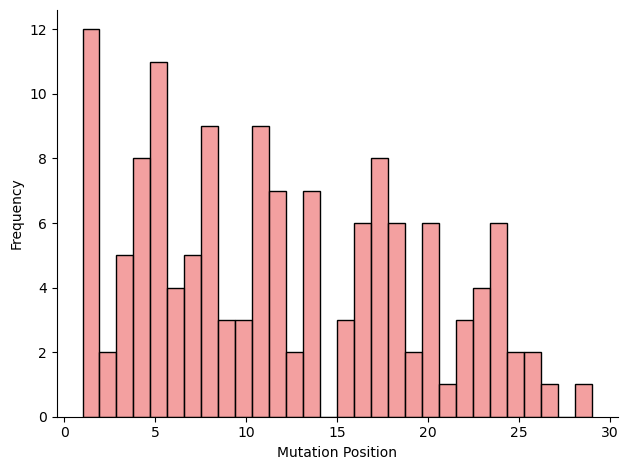

In [35]:
def plot_mutation_positions(mutation_positions):  
    # Histogram for mutation positions
    sns.histplot(mutation_positions, bins=30, color='lightcoral')
    plt.xlabel('Mutation Position')
    plt.ylabel('Frequency')
    
    # Enhance aesthetics
    plt.tight_layout()
    sns.despine()
    plt.show()

# Get the mutant subset from the selection policy
mutants_subset = [mutants[i] for i in cluster_inds]

mutation_positions = [mutant.mutation.position for mutant in mutants_subset]

plot_mutation_positions(mutation_positions)

# Analyze semantic change of wildtype and mutants

In [36]:
# Idea: Compute the cosine similarities of the mutants

# Get the mutant subset from the selection policy
mutants_subset = [mutants[i] for i in cluster_inds]

# Collect the mutant sequences
mutant_sequences = [x.mutated_sequence for x in mutants_subset]

# Compute the embeddings
mutant_outputs = esm2_650m_base_model.infer(mutant_sequences)

# Get the sequence embeddings
mutant_embeddings = np.array([x.sequence_embeddings for x in mutant_outputs])

wildtype_embeddings = np.array([x.plm_outputs["facebook/esm2_t33_650M_UR50D"].sequence_embeddings for x in mutants_subset])

/homes/abrace/.conda/envs/sdl-amp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 20.17it/s]


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_pairwise_cosine_similarity(embeddings1, embeddings2):
    # Ensure the two sets of embeddings have the same length
    assert len(embeddings1) == len(embeddings2), "The two lists of embeddings must have the same length"
    
    # Compute cosine similarity for each pair of embeddings
    similarities = []
    for emb1, emb2 in zip(embeddings1, embeddings2):
        similarity = cosine_similarity([emb1], [emb2])[0][0]
        similarities.append(similarity)
    
    return similarities

In [38]:
mutant_semantic_change = compute_pairwise_cosine_similarity(wildtype_embeddings, mutant_embeddings)

array([[<Axes: title={'center': '0'}>]], dtype=object)

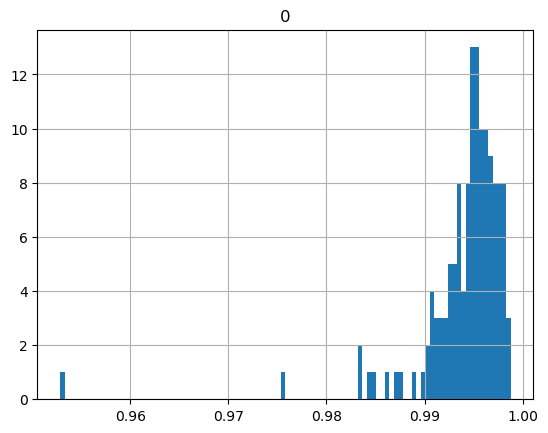

In [39]:
# Take away: most mutants have similar semantics as the wildtype
pd.DataFrame(mutant_semantic_change).hist(bins=100)

# EsmFold analysis

In [17]:
from transformers import AutoTokenizer
from transformers import EsmForProteinFolding

In [18]:
# Load the model
model = EsmForProteinFolding.from_pretrained(
    'facebook/esmfold_v1', low_cpu_mem_usage=True
)
tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")

# Load the model to GPU
model = model.cuda()

Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ptms, bad_indices = [], []
for idx, mutant in tqdm(enumerate(mutants)):
    try:
        # Tokenize the input sequence
        inputs = tokenizer(
            [mutant.mutated_sequence.sequence],
            return_tensors="pt",
            add_special_tokens=False,
            padding=True
        )
        # Move the inputs to device
        inputs = inputs.to(model.device)
        
        # Fold the sequence
        output = model(**inputs)
        
        # Collect the outputs
        ptms.append(output.ptm.item())
    except RuntimeError:
        bad_indices.append(idx)
        print("bad index", idx)

array([[<Axes: title={'center': '0'}>]], dtype=object)

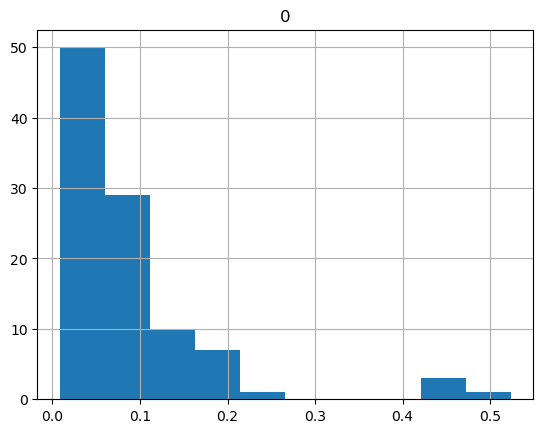

In [20]:
pd.DataFrame(ptms).hist(bins=10)